In [1]:
import random
import numpy as np
import random
import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras import models
from keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# number of characters in a word.
# for instance abccba has nb_chars = 6
nb_chars = 6

# number of possible characters used during the encoding.
# for instance abcde leads to 01234 has nb_letters = 5
nb_letters = 26

# number of words samples to be generated 
nb_words = 10000

# percentage of words that will be used for validation
percentage_split = 0.30

# number of epochs for fitting the model training step
nb_epochs = 200

In [3]:
# total number of combinations
nb_letters**nb_chars

308915776

In [4]:
def create_inputs(nb_words, nb_chars, nb_letters):
    '''Create a numpy array of nb_words rows with nb_chars columns each element
    being a random letter of nb_letters (a, b...)'''
    words = np.zeros((nb_words, nb_chars), dtype=int)
    
    for w in range(nb_words):
        optim_tentative = False
        if optim_tentative == True and w%10 != 0:
            i = random.randint(0, nb_letters-1)
            for c in range(nb_chars):
                words[w, c] = ord('a') + i
        else:
            for c in range(nb_chars):
                i = random.randint(0, nb_letters-1)
                words[w, c] = ord('a') + i
                
    return words


def encrypt(words, nb_words, nb_chars):
    '''Encrypt each element of a numpy array of nb_words rows with nb_chars 
    columns each item with a secret algorithm'''
    
    encrypted_words = words.copy()
    encrypted_words_probs = np.zeros((nb_words, nb_chars, nb_chars))
    
    #val_max = -1
    
    for w in range(nb_words):
        for c in range(nb_chars): # 0,1,2,3,4
            encrypted_words[w,c] = int(words[w,c]) - 49
            val = encrypted_words[w,c] - 48
            
            #if val > val_max:
            #    val_max = val
            
            # add entropy (i.e. mistakes in the encryption)
            #epsilon = random.randint(0, 100)
            #if epsilon == 5 and val != val_max:
            #val +=1
            
            #print('w:',w,', c:',c,', [wc]:', val)
            #encrypted_words_probs[w, c, val ] = 1.0
            encrypted_words[w,c] = val
    return encrypted_words

In [5]:
nb_features = nb_chars

# This returns a tensor
inputs = layers.Input(shape=(nb_chars,), dtype='float32', name='main_input')

# a layer instance is callable on a tensor, and returns a tensor
x = layers.Dense(4096, activation='relu', name='hl_1')(inputs)
#x = layers.Dense(2048, activation='relu', name='hl_1')(inputs)
#x = layers.Dense(64, activation='relu', name='hl_2')(x)

outputs = []
losses = {}
for o in range(nb_chars):
    name_i = 'output_'+str(o)
    output_i = layers.Dense(nb_letters, activation='softmax', dtype='float32', name=name_i)(x)
    outputs.append(output_i)
    losses[name_i] = 'categorical_crossentropy'

coding_model = keras.models.Model(inputs=inputs, outputs=outputs)

coding_model.compile(optimizer='rmsprop',
                     loss=losses,
                     metrics=['accuracy'])       

In [6]:
print(coding_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 6)            0                                            
__________________________________________________________________________________________________
hl_1 (Dense)                    (None, 4096)         28672       main_input[0][0]                 
__________________________________________________________________________________________________
output_0 (Dense)                (None, 26)           106522      hl_1[0][0]                       
__________________________________________________________________________________________________
output_1 (Dense)                (None, 26)           106522      hl_1[0][0]                       
__________________________________________________________________________________________________
output_2 (

In [7]:
def print_readable_inputs(x):
    words = []
    for w in x:
        word = ''
        for c in w:
            word += chr(c)
        words.append(word)
   
    print(words)

In [8]:
def print_readable_outputs_(outputs, nb_words, nb_chars):
    
    # outputs are listed : first, per char, second by sample, third by letter probability
    words = [''] * nb_words
    
    c_i = 0
    for char in outputs:

        s_i = 0
        for sample in char:

            l_i = 0
            best_value = -float('inf')
            best_letter = -1
            for letter_probs in sample:
                if letter_probs > best_value:
                    best_value = letter_probs
                    best_letter = l_i
                l_i += 1
            words[s_i] += str(best_letter)
            if c_i != nb_chars - 1:
                words[s_i] += ' '
            s_i += 1
        c_i += 1
    print(words)

In [9]:
def print_readable_outputs(outputs, nb_words, nb_chars):
    
    # outputs are listed : first, per char, second by sample, third by letter probability
    words = [''] * nb_words
    c_i = 0
    for char in outputs:
        s_i = 0
        for sample in char:
            best_letter = np.argmax(sample)
            words[s_i] += str(best_letter)
            if c_i != nb_chars - 1:
                words[s_i] += ' '
            s_i += 1
        c_i += 1
    print(words)

In [10]:
x = create_inputs(nb_words, nb_chars, nb_letters)
print('x: (as readable inputs)')

first_n_samples = 4

print_readable_inputs(x[:first_n_samples])
print('x (partial):\n', x[:first_n_samples], 'out of ',len(x))
print()

# process the x data as useful ANN input data
scaler = StandardScaler()
x_train  = scaler.fit_transform(x)

print('x_train:\n', x_train[:first_n_samples], 'out of ',len(x_train))
print()

# create output data for training
y = encrypt(x, nb_words, nb_chars)
print('y (readable):\n', y)
print()

# process the y data as useful ANN output data
y_train0 = keras.utils.to_categorical(y, nb_letters)
print('y (less readable):\n', y_train0[:first_n_samples], 'out of ',len(y_train0))
print('')

# process the y data as useful ANN multiple-outputs data
y_train = []
for c in range(nb_chars):
    # extract each 'char' colomn from the global y_train0 tensor
    # in order to have multiplue yi_train outputs tensors
    yi_train = y_train0[:,c,:]
    y_train.append(yi_train)

# Not really displayable, henced commented
#print('y_train):')
#print(y_train[:first_n_samples])

x: (as readable inputs)
['mwvrcj', 'kzfuxv', 'enxuah', 'raiold']
x (partial):
 [[109 119 118 114  99 106]
 [107 122 102 117 120 118]
 [101 110 120 117  97 104]
 [114  97 105 111 108 100]] out of  10000

x_train:
 [[-0.08164801  1.26169656  1.13668048  0.6181665  -1.40331438 -0.46845706]
 [-0.34842797  1.66022773 -0.98986883  1.01735273  1.39555751  1.1327406 ]
 [-1.14876786  0.06610304  1.40249915  1.01735273 -1.66987361 -0.73532334]
 [ 0.5853019  -1.66086538 -0.59114084  0.21898026 -0.20379786 -1.2690559 ]] out of  10000

y (readable):
 [[12 22 21 17  2  9]
 [10 25  5 20 23 21]
 [ 4 13 23 20  0  7]
 ...
 [11  1  7 10 21  6]
 [ 7  7  5 16 14 11]
 [11 19 19 21 11 24]]

y (less readable):
 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
history = coding_model.fit(x_train, y_train, validation_split=percentage_split, batch_size=32, epochs=nb_epochs, verbose=1)

Train on 7000 samples, validate on 3000 samples
Epoch 1/200
7000/7000 [==============================] - 2s 259us/step - loss: 15.1059 - output_0_loss: 2.5172 - output_1_loss: 2.5157 - output_2_loss: 2.5133 - output_3_loss: 2.5302 - output_4_loss: 2.5181 - output_5_loss: 2.5114 - output_0_acc: 0.1614 - output_1_acc: 0.1541 - output_2_acc: 0.1603 - output_3_acc: 0.1574 - output_4_acc: 0.1546 - output_5_acc: 0.1656 - val_loss: 13.3627 - val_output_0_loss: 2.2243 - val_output_1_loss: 2.2519 - val_output_2_loss: 2.2190 - val_output_3_loss: 2.1919 - val_output_4_loss: 2.2482 - val_output_5_loss: 2.2274 - val_output_0_acc: 0.1960 - val_output_1_acc: 0.1953 - val_output_2_acc: 0.2010 - val_output_3_acc: 0.2143 - val_output_4_acc: 0.2167 - val_output_5_acc: 0.1840
Epoch 2/200
7000/7000 [==============================] - 1s 170us/step - loss: 12.5300 - output_0_loss: 2.0876 - output_1_loss: 2.0828 - output_2_loss: 2.0836 - output_3_loss: 2.0959 - output_4_loss: 2.0979 - output_5_loss: 2.0822 - 

7000/7000 [==============================] - 1s 169us/step - loss: 7.6086 - output_0_loss: 1.2785 - output_1_loss: 1.2504 - output_2_loss: 1.2451 - output_3_loss: 1.2772 - output_4_loss: 1.3064 - output_5_loss: 1.2510 - output_0_acc: 0.4890 - output_1_acc: 0.4976 - output_2_acc: 0.4983 - output_3_acc: 0.4846 - output_4_acc: 0.4746 - output_5_acc: 0.5034 - val_loss: 8.0371 - val_output_0_loss: 1.4199 - val_output_1_loss: 1.3511 - val_output_2_loss: 1.2703 - val_output_3_loss: 1.2817 - val_output_4_loss: 1.3876 - val_output_5_loss: 1.3266 - val_output_0_acc: 0.3943 - val_output_1_acc: 0.4407 - val_output_2_acc: 0.4883 - val_output_3_acc: 0.4900 - val_output_4_acc: 0.4693 - val_output_5_acc: 0.4497
Epoch 13/200
7000/7000 [==============================] - 1s 155us/step - loss: 7.3262 - output_0_loss: 1.2404 - output_1_loss: 1.2058 - output_2_loss: 1.1895 - output_3_loss: 1.2313 - output_4_loss: 1.2557 - output_5_loss: 1.2036 - output_0_acc: 0.5099 - output_1_acc: 0.5167 - output_2_acc: 0.

7000/7000 [==============================] - 1s 162us/step - loss: 5.4533 - output_0_loss: 0.9196 - output_1_loss: 0.8931 - output_2_loss: 0.8809 - output_3_loss: 0.9124 - output_4_loss: 0.9480 - output_5_loss: 0.8995 - output_0_acc: 0.6366 - output_1_acc: 0.6536 - output_2_acc: 0.6597 - output_3_acc: 0.6467 - output_4_acc: 0.6327 - output_5_acc: 0.6499 - val_loss: 6.3647 - val_output_0_loss: 1.1190 - val_output_1_loss: 0.9998 - val_output_2_loss: 0.9923 - val_output_3_loss: 0.9553 - val_output_4_loss: 1.2240 - val_output_5_loss: 1.0743 - val_output_0_acc: 0.5233 - val_output_1_acc: 0.5767 - val_output_2_acc: 0.5883 - val_output_3_acc: 0.6130 - val_output_4_acc: 0.5107 - val_output_5_acc: 0.5597
Epoch 24/200
7000/7000 [==============================] - 1s 163us/step - loss: 5.3115 - output_0_loss: 0.8994 - output_1_loss: 0.8654 - output_2_loss: 0.8498 - output_3_loss: 0.8942 - output_4_loss: 0.9308 - output_5_loss: 0.8719 - output_0_acc: 0.6464 - output_1_acc: 0.6647 - output_2_acc: 0.

7000/7000 [==============================] - 1s 155us/step - loss: 4.1626 - output_0_loss: 0.7043 - output_1_loss: 0.6727 - output_2_loss: 0.6618 - output_3_loss: 0.7015 - output_4_loss: 0.7367 - output_5_loss: 0.6856 - output_0_acc: 0.7370 - output_1_acc: 0.7494 - output_2_acc: 0.7661 - output_3_acc: 0.7371 - output_4_acc: 0.7244 - output_5_acc: 0.7511 - val_loss: 5.2635 - val_output_0_loss: 0.8314 - val_output_1_loss: 0.8802 - val_output_2_loss: 0.8206 - val_output_3_loss: 0.8551 - val_output_4_loss: 0.9459 - val_output_5_loss: 0.9304 - val_output_0_acc: 0.6617 - val_output_1_acc: 0.6180 - val_output_2_acc: 0.6637 - val_output_3_acc: 0.6700 - val_output_4_acc: 0.6080 - val_output_5_acc: 0.5943
Epoch 35/200
7000/7000 [==============================] - 1s 145us/step - loss: 4.1051 - output_0_loss: 0.6972 - output_1_loss: 0.6671 - output_2_loss: 0.6519 - output_3_loss: 0.6907 - output_4_loss: 0.7249 - output_5_loss: 0.6733 - output_0_acc: 0.7366 - output_1_acc: 0.7510 - output_2_acc: 0.

7000/7000 [==============================] - 1s 151us/step - loss: 3.3123 - output_0_loss: 0.5606 - output_1_loss: 0.5391 - output_2_loss: 0.5131 - output_3_loss: 0.5633 - output_4_loss: 0.5985 - output_5_loss: 0.5377 - output_0_acc: 0.7970 - output_1_acc: 0.8084 - output_2_acc: 0.8281 - output_3_acc: 0.8047 - output_4_acc: 0.7844 - output_5_acc: 0.8124 - val_loss: 4.2546 - val_output_0_loss: 0.7260 - val_output_1_loss: 0.7182 - val_output_2_loss: 0.6251 - val_output_3_loss: 0.6763 - val_output_4_loss: 0.8134 - val_output_5_loss: 0.6956 - val_output_0_acc: 0.7120 - val_output_1_acc: 0.6993 - val_output_2_acc: 0.7633 - val_output_3_acc: 0.7473 - val_output_4_acc: 0.6543 - val_output_5_acc: 0.7150
Epoch 46/200
7000/7000 [==============================] - 1s 155us/step - loss: 3.2384 - output_0_loss: 0.5492 - output_1_loss: 0.5245 - output_2_loss: 0.5036 - output_3_loss: 0.5449 - output_4_loss: 0.5833 - output_5_loss: 0.5328 - output_0_acc: 0.8083 - output_1_acc: 0.8163 - output_2_acc: 0.

7000/7000 [==============================] - 1s 148us/step - loss: 2.6546 - output_0_loss: 0.4520 - output_1_loss: 0.4309 - output_2_loss: 0.4024 - output_3_loss: 0.4486 - output_4_loss: 0.4849 - output_5_loss: 0.4357 - output_0_acc: 0.8496 - output_1_acc: 0.8584 - output_2_acc: 0.8754 - output_3_acc: 0.8570 - output_4_acc: 0.8317 - output_5_acc: 0.8559 - val_loss: 3.8361 - val_output_0_loss: 0.7052 - val_output_1_loss: 0.5675 - val_output_2_loss: 0.6110 - val_output_3_loss: 0.5917 - val_output_4_loss: 0.7129 - val_output_5_loss: 0.6478 - val_output_0_acc: 0.7177 - val_output_1_acc: 0.8027 - val_output_2_acc: 0.7463 - val_output_3_acc: 0.7610 - val_output_4_acc: 0.7157 - val_output_5_acc: 0.7283
Epoch 57/200
7000/7000 [==============================] - 1s 154us/step - loss: 2.6129 - output_0_loss: 0.4476 - output_1_loss: 0.4234 - output_2_loss: 0.3945 - output_3_loss: 0.4424 - output_4_loss: 0.4802 - output_5_loss: 0.4248 - output_0_acc: 0.8519 - output_1_acc: 0.8643 - output_2_acc: 0.

7000/7000 [==============================] - 1s 145us/step - loss: 2.1440 - output_0_loss: 0.3653 - output_1_loss: 0.3427 - output_2_loss: 0.3211 - output_3_loss: 0.3617 - output_4_loss: 0.4034 - output_5_loss: 0.3497 - output_0_acc: 0.8870 - output_1_acc: 0.8933 - output_2_acc: 0.9074 - output_3_acc: 0.8849 - output_4_acc: 0.8659 - output_5_acc: 0.8903 - val_loss: 3.3507 - val_output_0_loss: 0.5300 - val_output_1_loss: 0.5889 - val_output_2_loss: 0.5032 - val_output_3_loss: 0.5197 - val_output_4_loss: 0.6881 - val_output_5_loss: 0.5208 - val_output_0_acc: 0.8040 - val_output_1_acc: 0.7567 - val_output_2_acc: 0.8247 - val_output_3_acc: 0.8067 - val_output_4_acc: 0.7613 - val_output_5_acc: 0.7977
Epoch 68/200
7000/7000 [==============================] - 1s 159us/step - loss: 2.1235 - output_0_loss: 0.3612 - output_1_loss: 0.3439 - output_2_loss: 0.3153 - output_3_loss: 0.3584 - output_4_loss: 0.4016 - output_5_loss: 0.3432 - output_0_acc: 0.8876 - output_1_acc: 0.8960 - output_2_acc: 0.

7000/7000 [==============================] - 1s 152us/step - loss: 1.7525 - output_0_loss: 0.2985 - output_1_loss: 0.2794 - output_2_loss: 0.2582 - output_3_loss: 0.2957 - output_4_loss: 0.3378 - output_5_loss: 0.2827 - output_0_acc: 0.9106 - output_1_acc: 0.9230 - output_2_acc: 0.9320 - output_3_acc: 0.9139 - output_4_acc: 0.8916 - output_5_acc: 0.9141 - val_loss: 2.7422 - val_output_0_loss: 0.4836 - val_output_1_loss: 0.4514 - val_output_2_loss: 0.4250 - val_output_3_loss: 0.3980 - val_output_4_loss: 0.5153 - val_output_5_loss: 0.4689 - val_output_0_acc: 0.8183 - val_output_1_acc: 0.8317 - val_output_2_acc: 0.8500 - val_output_3_acc: 0.8707 - val_output_4_acc: 0.8057 - val_output_5_acc: 0.8330
Epoch 79/200
7000/7000 [==============================] - 1s 155us/step - loss: 1.7097 - output_0_loss: 0.2910 - output_1_loss: 0.2726 - output_2_loss: 0.2501 - output_3_loss: 0.2861 - output_4_loss: 0.3321 - output_5_loss: 0.2778 - output_0_acc: 0.9137 - output_1_acc: 0.9240 - output_2_acc: 0.

7000/7000 [==============================] - 1s 151us/step - loss: 1.4181 - output_0_loss: 0.2406 - output_1_loss: 0.2235 - output_2_loss: 0.2087 - output_3_loss: 0.2351 - output_4_loss: 0.2820 - output_5_loss: 0.2282 - output_0_acc: 0.9311 - output_1_acc: 0.9419 - output_2_acc: 0.9414 - output_3_acc: 0.9346 - output_4_acc: 0.9149 - output_5_acc: 0.9403 - val_loss: 2.5770 - val_output_0_loss: 0.4260 - val_output_1_loss: 0.3968 - val_output_2_loss: 0.3660 - val_output_3_loss: 0.3282 - val_output_4_loss: 0.5878 - val_output_5_loss: 0.4722 - val_output_0_acc: 0.8420 - val_output_1_acc: 0.8637 - val_output_2_acc: 0.8843 - val_output_3_acc: 0.8953 - val_output_4_acc: 0.7833 - val_output_5_acc: 0.8130
Epoch 90/200
7000/7000 [==============================] - 1s 147us/step - loss: 1.3991 - output_0_loss: 0.2337 - output_1_loss: 0.2249 - output_2_loss: 0.2060 - output_3_loss: 0.2304 - output_4_loss: 0.2776 - output_5_loss: 0.2265 - output_0_acc: 0.9376 - output_1_acc: 0.9386 - output_2_acc: 0.

7000/7000 [==============================] - 1s 156us/step - loss: 1.1646 - output_0_loss: 0.1974 - output_1_loss: 0.1862 - output_2_loss: 0.1671 - output_3_loss: 0.1948 - output_4_loss: 0.2341 - output_5_loss: 0.1850 - output_0_acc: 0.9493 - output_1_acc: 0.9537 - output_2_acc: 0.9577 - output_3_acc: 0.9459 - output_4_acc: 0.9331 - output_5_acc: 0.9517 - val_loss: 2.1482 - val_output_0_loss: 0.3233 - val_output_1_loss: 0.3910 - val_output_2_loss: 0.2963 - val_output_3_loss: 0.3332 - val_output_4_loss: 0.3937 - val_output_5_loss: 0.4105 - val_output_0_acc: 0.8973 - val_output_1_acc: 0.8563 - val_output_2_acc: 0.8983 - val_output_3_acc: 0.9027 - val_output_4_acc: 0.8547 - val_output_5_acc: 0.8323
Epoch 101/200
7000/7000 [==============================] - 1s 155us/step - loss: 1.1306 - output_0_loss: 0.1894 - output_1_loss: 0.1799 - output_2_loss: 0.1622 - output_3_loss: 0.1864 - output_4_loss: 0.2301 - output_5_loss: 0.1826 - output_0_acc: 0.9511 - output_1_acc: 0.9529 - output_2_acc: 0

7000/7000 [==============================] - 1s 153us/step - loss: 0.9442 - output_0_loss: 0.1560 - output_1_loss: 0.1490 - output_2_loss: 0.1375 - output_3_loss: 0.1569 - output_4_loss: 0.1926 - output_5_loss: 0.1522 - output_0_acc: 0.9620 - output_1_acc: 0.9660 - output_2_acc: 0.9660 - output_3_acc: 0.9576 - output_4_acc: 0.9440 - output_5_acc: 0.9629 - val_loss: 1.7983 - val_output_0_loss: 0.3354 - val_output_1_loss: 0.2599 - val_output_2_loss: 0.2546 - val_output_3_loss: 0.3191 - val_output_4_loss: 0.3835 - val_output_5_loss: 0.2458 - val_output_0_acc: 0.8867 - val_output_1_acc: 0.9163 - val_output_2_acc: 0.9190 - val_output_3_acc: 0.8817 - val_output_4_acc: 0.8610 - val_output_5_acc: 0.9277
Epoch 112/200
7000/7000 [==============================] - 1s 155us/step - loss: 0.9258 - output_0_loss: 0.1553 - output_1_loss: 0.1492 - output_2_loss: 0.1300 - output_3_loss: 0.1527 - output_4_loss: 0.1923 - output_5_loss: 0.1464 - output_0_acc: 0.9610 - output_1_acc: 0.9620 - output_2_acc: 0

7000/7000 [==============================] - 1s 146us/step - loss: 0.7719 - output_0_loss: 0.1286 - output_1_loss: 0.1212 - output_2_loss: 0.1110 - output_3_loss: 0.1277 - output_4_loss: 0.1608 - output_5_loss: 0.1226 - output_0_acc: 0.9670 - output_1_acc: 0.9694 - output_2_acc: 0.9724 - output_3_acc: 0.9680 - output_4_acc: 0.9569 - output_5_acc: 0.9729 - val_loss: 1.5741 - val_output_0_loss: 0.2801 - val_output_1_loss: 0.2632 - val_output_2_loss: 0.2253 - val_output_3_loss: 0.2634 - val_output_4_loss: 0.3045 - val_output_5_loss: 0.2376 - val_output_0_acc: 0.9100 - val_output_1_acc: 0.9107 - val_output_2_acc: 0.9273 - val_output_3_acc: 0.9130 - val_output_4_acc: 0.8933 - val_output_5_acc: 0.9220
Epoch 123/200
7000/7000 [==============================] - 1s 149us/step - loss: 0.7551 - output_0_loss: 0.1227 - output_1_loss: 0.1215 - output_2_loss: 0.1055 - output_3_loss: 0.1257 - output_4_loss: 0.1617 - output_5_loss: 0.1179 - output_0_acc: 0.9704 - output_1_acc: 0.9694 - output_2_acc: 0

7000/7000 [==============================] - 1s 145us/step - loss: 0.6360 - output_0_loss: 0.1070 - output_1_loss: 0.0998 - output_2_loss: 0.0914 - output_3_loss: 0.1045 - output_4_loss: 0.1331 - output_5_loss: 0.1002 - output_0_acc: 0.9753 - output_1_acc: 0.9783 - output_2_acc: 0.9794 - output_3_acc: 0.9747 - output_4_acc: 0.9676 - output_5_acc: 0.9783 - val_loss: 1.4243 - val_output_0_loss: 0.3067 - val_output_1_loss: 0.2216 - val_output_2_loss: 0.1840 - val_output_3_loss: 0.1870 - val_output_4_loss: 0.2766 - val_output_5_loss: 0.2483 - val_output_0_acc: 0.8757 - val_output_1_acc: 0.9300 - val_output_2_acc: 0.9397 - val_output_3_acc: 0.9400 - val_output_4_acc: 0.9020 - val_output_5_acc: 0.9080
Epoch 134/200
7000/7000 [==============================] - 1s 149us/step - loss: 0.6161 - output_0_loss: 0.1024 - output_1_loss: 0.1000 - output_2_loss: 0.0890 - output_3_loss: 0.0981 - output_4_loss: 0.1324 - output_5_loss: 0.0942 - output_0_acc: 0.9771 - output_1_acc: 0.9774 - output_2_acc: 0

7000/7000 [==============================] - 1s 152us/step - loss: 0.5071 - output_0_loss: 0.0873 - output_1_loss: 0.0834 - output_2_loss: 0.0696 - output_3_loss: 0.0802 - output_4_loss: 0.1077 - output_5_loss: 0.0789 - output_0_acc: 0.9816 - output_1_acc: 0.9809 - output_2_acc: 0.9873 - output_3_acc: 0.9821 - output_4_acc: 0.9744 - output_5_acc: 0.9841 - val_loss: 1.2349 - val_output_0_loss: 0.2055 - val_output_1_loss: 0.1976 - val_output_2_loss: 0.1684 - val_output_3_loss: 0.1821 - val_output_4_loss: 0.2477 - val_output_5_loss: 0.2336 - val_output_0_acc: 0.9360 - val_output_1_acc: 0.9310 - val_output_2_acc: 0.9490 - val_output_3_acc: 0.9390 - val_output_4_acc: 0.9207 - val_output_5_acc: 0.9137
Epoch 145/200
7000/7000 [==============================] - 1s 143us/step - loss: 0.4978 - output_0_loss: 0.0809 - output_1_loss: 0.0809 - output_2_loss: 0.0717 - output_3_loss: 0.0810 - output_4_loss: 0.1041 - output_5_loss: 0.0792 - output_0_acc: 0.9817 - output_1_acc: 0.9833 - output_2_acc: 0

7000/7000 [==============================] - 1s 148us/step - loss: 0.4058 - output_0_loss: 0.0705 - output_1_loss: 0.0648 - output_2_loss: 0.0556 - output_3_loss: 0.0666 - output_4_loss: 0.0864 - output_5_loss: 0.0619 - output_0_acc: 0.9850 - output_1_acc: 0.9863 - output_2_acc: 0.9877 - output_3_acc: 0.9866 - output_4_acc: 0.9817 - output_5_acc: 0.9889 - val_loss: 1.1463 - val_output_0_loss: 0.2095 - val_output_1_loss: 0.1776 - val_output_2_loss: 0.1359 - val_output_3_loss: 0.1446 - val_output_4_loss: 0.2887 - val_output_5_loss: 0.1900 - val_output_0_acc: 0.9277 - val_output_1_acc: 0.9407 - val_output_2_acc: 0.9553 - val_output_3_acc: 0.9530 - val_output_4_acc: 0.8903 - val_output_5_acc: 0.9407
Epoch 156/200
7000/7000 [==============================] - 1s 159us/step - loss: 0.3978 - output_0_loss: 0.0656 - output_1_loss: 0.0620 - output_2_loss: 0.0543 - output_3_loss: 0.0651 - output_4_loss: 0.0847 - output_5_loss: 0.0661 - output_0_acc: 0.9853 - output_1_acc: 0.9876 - output_2_acc: 0

7000/7000 [==============================] - 1s 151us/step - loss: 0.3212 - output_0_loss: 0.0518 - output_1_loss: 0.0533 - output_2_loss: 0.0450 - output_3_loss: 0.0516 - output_4_loss: 0.0685 - output_5_loss: 0.0510 - output_0_acc: 0.9911 - output_1_acc: 0.9893 - output_2_acc: 0.9917 - output_3_acc: 0.9893 - output_4_acc: 0.9877 - output_5_acc: 0.9903 - val_loss: 1.0559 - val_output_0_loss: 0.1954 - val_output_1_loss: 0.1211 - val_output_2_loss: 0.1274 - val_output_3_loss: 0.1405 - val_output_4_loss: 0.2131 - val_output_5_loss: 0.2584 - val_output_0_acc: 0.9293 - val_output_1_acc: 0.9610 - val_output_2_acc: 0.9587 - val_output_3_acc: 0.9557 - val_output_4_acc: 0.9257 - val_output_5_acc: 0.9027
Epoch 167/200
7000/7000 [==============================] - 1s 169us/step - loss: 0.3149 - output_0_loss: 0.0528 - output_1_loss: 0.0511 - output_2_loss: 0.0431 - output_3_loss: 0.0492 - output_4_loss: 0.0679 - output_5_loss: 0.0507 - output_0_acc: 0.9899 - output_1_acc: 0.9914 - output_2_acc: 0

7000/7000 [==============================] - 1s 156us/step - loss: 0.2572 - output_0_loss: 0.0419 - output_1_loss: 0.0411 - output_2_loss: 0.0358 - output_3_loss: 0.0408 - output_4_loss: 0.0556 - output_5_loss: 0.0420 - output_0_acc: 0.9911 - output_1_acc: 0.9924 - output_2_acc: 0.9930 - output_3_acc: 0.9920 - output_4_acc: 0.9894 - output_5_acc: 0.9917 - val_loss: 0.9514 - val_output_0_loss: 0.1798 - val_output_1_loss: 0.1687 - val_output_2_loss: 0.1330 - val_output_3_loss: 0.1217 - val_output_4_loss: 0.1549 - val_output_5_loss: 0.1934 - val_output_0_acc: 0.9353 - val_output_1_acc: 0.9397 - val_output_2_acc: 0.9500 - val_output_3_acc: 0.9603 - val_output_4_acc: 0.9510 - val_output_5_acc: 0.9340
Epoch 178/200
7000/7000 [==============================] - 1s 161us/step - loss: 0.2528 - output_0_loss: 0.0423 - output_1_loss: 0.0418 - output_2_loss: 0.0340 - output_3_loss: 0.0380 - output_4_loss: 0.0569 - output_5_loss: 0.0398 - output_0_acc: 0.9927 - output_1_acc: 0.9914 - output_2_acc: 0

7000/7000 [==============================] - 1s 162us/step - loss: 0.2065 - output_0_loss: 0.0334 - output_1_loss: 0.0333 - output_2_loss: 0.0279 - output_3_loss: 0.0311 - output_4_loss: 0.0465 - output_5_loss: 0.0344 - output_0_acc: 0.9943 - output_1_acc: 0.9944 - output_2_acc: 0.9954 - output_3_acc: 0.9957 - output_4_acc: 0.9909 - output_5_acc: 0.9941 - val_loss: 0.7949 - val_output_0_loss: 0.1213 - val_output_1_loss: 0.1615 - val_output_2_loss: 0.0830 - val_output_3_loss: 0.1552 - val_output_4_loss: 0.1550 - val_output_5_loss: 0.1189 - val_output_0_acc: 0.9630 - val_output_1_acc: 0.9353 - val_output_2_acc: 0.9733 - val_output_3_acc: 0.9423 - val_output_4_acc: 0.9487 - val_output_5_acc: 0.9613
Epoch 189/200
7000/7000 [==============================] - 1s 160us/step - loss: 0.2011 - output_0_loss: 0.0345 - output_1_loss: 0.0306 - output_2_loss: 0.0281 - output_3_loss: 0.0301 - output_4_loss: 0.0444 - output_5_loss: 0.0333 - output_0_acc: 0.9937 - output_1_acc: 0.9957 - output_2_acc: 0

7000/7000 [==============================] - 1s 159us/step - loss: 0.1644 - output_0_loss: 0.0253 - output_1_loss: 0.0262 - output_2_loss: 0.0216 - output_3_loss: 0.0247 - output_4_loss: 0.0384 - output_5_loss: 0.0283 - output_0_acc: 0.9966 - output_1_acc: 0.9954 - output_2_acc: 0.9967 - output_3_acc: 0.9964 - output_4_acc: 0.9929 - output_5_acc: 0.9953 - val_loss: 0.8152 - val_output_0_loss: 0.2035 - val_output_1_loss: 0.1559 - val_output_2_loss: 0.0948 - val_output_3_loss: 0.1020 - val_output_4_loss: 0.1367 - val_output_5_loss: 0.1223 - val_output_0_acc: 0.9303 - val_output_1_acc: 0.9437 - val_output_2_acc: 0.9687 - val_output_3_acc: 0.9637 - val_output_4_acc: 0.9577 - val_output_5_acc: 0.9640
Epoch 200/200
7000/7000 [==============================] - 1s 162us/step - loss: 0.1600 - output_0_loss: 0.0260 - output_1_loss: 0.0273 - output_2_loss: 0.0216 - output_3_loss: 0.0223 - output_4_loss: 0.0370 - output_5_loss: 0.0259 - output_0_acc: 0.9960 - output_1_acc: 0.9947 - output_2_acc: 0

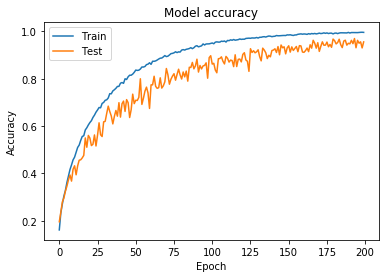

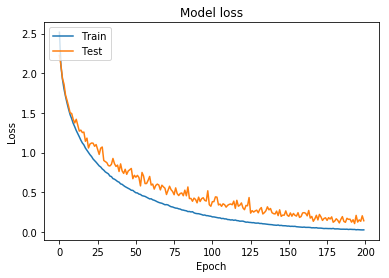

In [12]:
# Plot training & validation accuracy values (of first char only)
plt.plot(history.history['output_0_acc'])
plt.plot(history.history['val_output_0_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values (of first char only)
plt.plot(history.history['output_0_loss'])
plt.plot(history.history['val_output_0_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
nb_words_to_test = 10000

x_test = create_inputs(nb_words_to_test, nb_chars, nb_letters)
x_test_scaled  = scaler.transform(x_test)

y_test_raw = encrypt(x_test, nb_words_to_test, nb_chars)
y_test_raw_cate = keras.utils.to_categorical(y_test_raw, nb_letters)

# process the y data as useful ANN multiple-outputs data
y_test = []
for c in range(nb_chars):
    # extract each 'char' colomn from the global y_train0 tensor
    # in order to have multiplue yi_train outputs tensors
    yi_test = y_test_raw_cate[:,c,:]
    y_test.append(yi_test)


print('\n# Evaluate on test data')
results = coding_model.evaluate(x_test_scaled, y_test, batch_size=128)
for r in range(len(results)):
    print(coding_model.metrics_names[r],':',results[r])


# Evaluate on test data
 6016/10000 [=================>............] - ETA: 0s

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


10000/10000 [==============================] - 0s 18us/step
loss : 0.6605998941421509
output_0_loss : 0.1295211825966835
output_1_loss : 0.12847152075767518
output_2_loss : 0.09500231258273124
output_3_loss : 0.08859642367362976
output_4_loss : 0.12913943295478822
output_5_loss : 0.08986902555823326
output_0_acc : 0.9532
output_1_acc : 0.9573
output_2_acc : 0.9727
output_3_acc : 0.9767
output_4_acc : 0.9602
output_5_acc : 0.9736


In [14]:
nb_words_to_test = 3

x_test = create_inputs(nb_words_to_test, nb_chars, nb_letters)
print_readable_inputs(x_test)
print("x_test=\n", x_test)

x_test_scaled  = scaler.transform(x_test)
print("x_test_scaled=\n", x_test_scaled)
print('-->')

prediction = coding_model.predict(x_test_scaled)
#print(prediction)
print('prediction')
print_readable_outputs(prediction, nb_words_to_test, nb_chars)

print('check prediction')
y_test = encrypt(x_test, nb_words_to_test, nb_chars)
print("y_test=\n", y_test)

['wllydw', 'hdcnnd', 'jznzbg']
x_test=
 [[119 108 108 121 100 119]
 [104 100  99 110 110 100]
 [106 122 110 122  98 103]]
x_test_scaled=
 [[ 1.25225181 -0.19958441 -0.19241284  1.54960105 -1.27003477  1.26617374]
 [-0.74859791 -1.26233421 -1.38859683  0.08591818  0.06276137 -1.2690559 ]
 [-0.48181795  1.66022773  0.07340582  1.68266313 -1.536594   -0.86875648]]
-->
prediction
['22 11 11 24 3 22', '7 3 2 13 13 3', '9 25 13 25 1 6']
check prediction
y_test=
 [[22 11 11 24  3 22]
 [ 7  3  2 13 13  3]
 [ 9 25 13 25  1  6]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
